# Lesson 301 用神經網路擬合拋物線

When I read "TensorFlow in a Nutshell" series article (Ynote: "TensorFlow in a Nutshell — Part One Two Three–Camron's Blog") I feel the need to review Morvan's tf. So I do it now but with jupyter notebook.

In [1]:
import peforth

In [2]:
%%f if playing in jupyter notebook 
\ Now we redefine the 'unknown' command that does nothing at default  
: unknown ( token -- thing Y|N) // Try to find the unknown token in __main__
  py> getattr(sys.modules['__main__'],pop(),"Ûnknôwn") 
  py> str(tos())=="Ûnknôwn" if drop false else true then ;
  /// here after, when FORTH come accross an unknown token, instead of alerting 
  /// it try to find the token in python __main__ module name space.
: path-to-find-modules ( <path> -- ) // Add path to sys.path so "import module-name" can find the module
    CR word trim ( "path" ) py: sys.path.append(pop()) ;
code # print(nexttoken('\n')) end-code // Redefine \ command to print the comment line 


reDef unknown


In [3]:
"""
Know more, visit my Python tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
tensorflow: 1.1.0
matplotlib
numpy

這個例題看來是 "tensorflowTUT\tensorflow10_def_add_layer.py" 之後的幾課的簡化版本, 
示範 tensorflow 做 regression 擬合可以簡化到這麼幾行程式。但是簡化後,我比較難懂。要從
完整的版本看過來才好懂。 怎麼從 Weights biases Activation Functions 完整地把 neuron 
建起來，然後組合成 neural layer 等等細節。

"""
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [4]:
tf.set_random_seed(1)
np.random.seed(1)

In [8]:
# fake data
x0 = np.linspace(-1, 1, 100)    # shape (100,) 這是 array 裡面都是 scalar
x  = x0[:, np.newaxis]          # shape (100, 1) 這是 array 裡都是 [1] array
%f x0 :> [-5:] tib.
%f x :> [-5:] tib.

x0 :> [-5:] tib. \ ==> [0.91919192 0.93939394 0.95959596 0.97979798 1.        ] (<class 'numpy.ndarray'>)
x :> [-5:] tib. \ ==> [[0.91919192]
 [0.93939394]
 [0.95959596]
 [0.97979798]
 [1.        ]] (<class 'numpy.ndarray'>)


### np.newaxis 用法非常奇怪的東西，它不是用 function 形式被 call 的，而是直接放進 ndarray 式子裡想要的地方，顯示 python 非常靈活的特色。
```
>>> a = np.array([[1,2],[3,4]])
>>> b = a[:,np.newaxis]  # 把原來 a 裡面的第一層東西都 [加套一層方括號]
>>> a
array([[1, 2],
       [3, 4]])
>>> a.shape
(2, 2)
>>> b
array([[[1, 2]],
       [[3, 4]]])
>>> b.shape
(2, 1, 2)
>>>
>>> c = np.array([[[3]]])
>>> c.shape
(1, 1, 1)
>>>
```

In [13]:
noise = np.random.normal(0, 0.1, size=x.shape)
%f x :> shape tib.
%f noise :> [-4:] tib.

x :> shape tib. \ ==> (100, 1) (<class 'tuple'>)
noise :> [-4:] tib. \ ==> [[ 0.05288797]
 [-0.22370865]
 [-0.11077125]
 [-0.00177183]] (<class 'numpy.ndarray'>)


```
這兩個寫法是一樣的
>>> np.random.normal(0, 0.1, size=(10,)) --> array([ 0.126344  ,  0.05828024, -0.0370982 , -0.06087167, -0.06704939,
>>> np.random.normal(0, 0.1, size=10) -----> array([-0.14486368, -0.05000549,  0.10604624, -0.08139904,  0.07342721,

>>> np.random.normal(0, 0.1, size=(10,1,2))  # size 可以很靈活
array([[[-0.11312059, -0.03460451]],
       [[-0.08800578,  0.03735402]], ... snip ... 
       [[ 0.02917306, -0.1791073 ]]])
       
>>> np.random.normal(0, 0.1, size=(3,3,3))
array([[[ 0.16249447,  0.02286981, -0.09342966],
        [ 0.05509977,  0.2053997 , -0.04976709],
        [ 0.16954797,  0.01231271, -0.1071088 ]],
       ... snip ...
       [[ 0.02013086, -0.09057076,  0.06521537],
        [-0.11177483, -0.09783154, -0.00251611],
        [-0.22728158,  0.16864931, -0.16219369]]])
```

In [14]:
y = np.power(x, 2) + noise  # shape (100, 1) + some noise
%f y :> [-5:] tib.

y :> [-5:] tib. \ ==> [[0.76205099]
 [0.93534895]
 [0.69711575]
 [0.84923283]
 [0.99822817]] (<class 'numpy.ndarray'>)


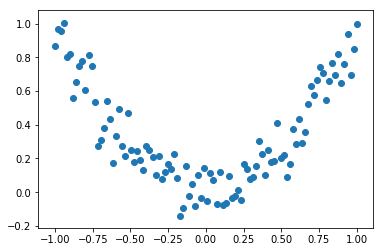

In [15]:
# plot data
plt.scatter(x, y)
plt.show()

In [17]:
tf_x = tf.placeholder(tf.float32, x.shape)     # input x
tf_y = tf.placeholder(tf.float32, y.shape)     # input y

%f tf_x tib.
%f tf_y tib.

tf_x tib. \ ==> Tensor("Placeholder:0", shape=(100, 1), dtype=float32) (<class 'tensorflow.python.framework.ops.Tensor'>)
tf_y tib. \ ==> Tensor("Placeholder_1:0", shape=(100, 1), dtype=float32) (<class 'tensorflow.python.framework.ops.Tensor'>)


In [18]:
# neural network layers
l1 = tf.layers.dense(tf_x, 10, tf.nn.relu)          # hidden layer
output = tf.layers.dense(l1, 1)                     # output layer

loss = tf.losses.mean_squared_error(tf_y, output)   # compute cost
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5)
train_op = optimizer.minimize(loss)

### 這是我最早 study 時做的紀錄
```
x0 = {ndarray} [-1.         -0.97979798 -0.95959596 -0.93939394 -0.91919192 -0.8989899\n -0.87878788 -0.85858586 -0.83838384 -0.81818182 -0.7979798  -0.77777778\n -0.75757576 -0.73737374 -0.71717172 -0.6969697  -0.67676768 -0.65656566\n -0.63636364 -0.61616162 -0.5959596  -
x = {ndarray} [[-1.        ]\n [-0.97979798]\n [-0.95959596]\n [-0.93939394]\n [-0.91919192]\n [-0.8989899 ]\n [-0.87878788]\n [-0.85858586]\n [-0.83838384]\n [-0.81818182]\n [-0.7979798 ]\n [-0.77777778]\n [-0.75757576]\n [-0.73737374]\n [-0.71717172]\n [-0.6969697 ]\n [-0.67676768]\n 
y = {ndarray} [[ 1.16243454]\n [ 0.89882844]\n [ 0.86800723]\n [ 0.77516411]\n [ 0.93145455]\n [ 0.57802897]\n [ 0.94674931]\n [ 0.66104899]\n [ 0.73479137]\n [ 0.64448445]\n [ 0.78298255]\n [ 0.3989242 ]\n [ 0.54167931]\n [ 0.50531459]\n [ 0.62771222]\n [ 0.37577763]\n [ 0.44077167]\n 
noise = {ndarray} [[ 0.16243454]\n [-0.06117564]\n [-0.05281718]\n [-0.10729686]\n [ 0.08654076]\n [-0.23015387]\n [ 0.17448118]\n [-0.07612069]\n [ 0.03190391]\n [-0.02493704]\n [ 0.14621079]\n [-0.20601407]\n [-0.03224172]\n [-0.03840544]\n [ 0.11337694]\n [-0.10998913]\n [-0.01724282]\n 
tf_x = {Tensor} Tensor("Placeholder:0", shape=(100, 1), dtype=float32)
tf_y = {Tensor} Tensor("Placeholder_1:0", shape=(100, 1), dtype=float32)
l1 = {Tensor} Tensor("dense/Relu:0", shape=(100, 10), dtype=float32)
loss = {Tensor} Tensor("mean_squared_error/value:0", shape=(), dtype=float32)
output = {Tensor} Tensor("dense_2/BiasAdd:0", shape=(100, 1), dtype=float32)
optimizer = {GradientDescentOptimizer} <tensorflow.python.training.gradient_descent.GradientDescentOptimizer object at 0x000001F419E34EF0>
train_op = {Operation} name: "GradientDescent"\nop: "NoOp"\ninput: "^GradientDescent/update_dense/kernel/ApplyGradientDescent"\ninput: "^GradientDescent/update_dense/bias/ApplyGradientDescent"\ninput: "^GradientDescent/update_dense_1/kernel/ApplyGradientDescent"\ninput: "^GradientDes
```

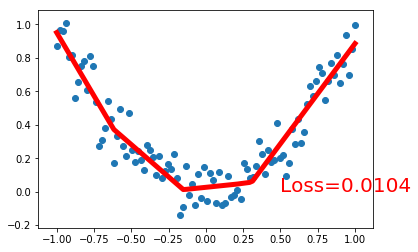

In [19]:
sess = tf.Session()                                 # control training and others
sess.run(tf.global_variables_initializer())         # initialize var in graph

plt.ion()   # something about plotting, i-something on

for step in range(1000):
    # train and net output
    # _, l, pred = sess.run([train_op, loss, output], {tf_x: x, tf_y: y})
    pred, l, _ = sess.run([output, loss, train_op], {tf_x: x, tf_y: y})
        # [ ] 這裡面是先有 output 然猴才有 loss 最後才可以做 train_op.
        # 一口氣全下很奇怪，而且順序也可疑 --> 故意把順序顛倒 ... 結果還是一樣!!
    if step % 5 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x, y)
        plt.plot(x, pred, 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % l, fontdict={'size': 20, 'color': 'red'})
        plt.pause(0.1)

plt.ioff()  # i-something off
plt.show()